In [2]:
import torch

# Check if CUDA (GPU) is available
if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPU.")
    print("Number of available GPUs:", torch.cuda.device_count())
    print("Current GPU device:", torch.cuda.current_device())
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPU.
Number of available GPUs: 1
Current GPU device: 0
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [3]:
import torch

# Before starting the training loop
torch.cuda.empty_cache()

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.transforms import transforms
import torch.optim as optim
import os
import cv2
from glob import glob
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, confusion_matrix

In [5]:
dataset_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data"
train_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Training"
test_path = "C:/Users/91623/Desktop/Brain_tumor_research/Data/Testing"
image_size = (299,299)
num_classes = 5
train_paths = glob(f"{train_path}/*/*.jpg")
test_paths = glob(f"{test_path}/*/*.jpg")

In [6]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [7]:
class dataset(Dataset):
    def __init__(self,paths,transform=None):
        self.paths = paths
        self.transform = transform
        self.labels = [self.get_label(path) for path in self.paths]
        self.labels_to_index = {label:index for index,label in enumerate(list(set(self.labels)))}
    
    def __getitem__(self,index):
        img_path = self.paths[index]
        img = Image.open(img_path).convert('RGB') 
        label = self.labels[index]
        label_index = self.labels_to_index[label]
        
        if self.transform:
            img = self.transform(img)
        
        return img, label_index,label
    
    
    def __len__(self):
        return len(self.paths)
    
    
    def get_label(self, path):
        return os.path.basename(os.path.dirname(path))

In [8]:
train_dataset = dataset(train_paths, transform=train_transform)
test_dataset = dataset(test_paths, transform=test_transform)
val_dataset, test_dataset = train_test_split(test_dataset,test_size=0.5, random_state=ord("H"))

In [9]:

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


import torch
import torch.nn as nn
from torchvision import models

class CustomInceptionV3(nn.Module):
    def __init__(self, num_classes):
        super(CustomInceptionV3, self).__init__()
        self.inception = models.inception_v3(pretrained=True, aux_logits=False)
        
        # Remove the final fully connected layer
        self.inception.fc = nn.Identity()
        
        # Add custom layers
        self.conv3 = nn.Conv2d(2048, 128, kernel_size=4, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        
        self.conv4 = nn.Conv2d(128, 128, kernel_size=4, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        # Fully connected layers
        # Placeholder for input size, will update after determining the correct size
        self.fc1_input_size = 128 * 1 * 1  # Update this based on your actual input size
        self.fc1 = nn.Linear(self.fc1_input_size, 512)
        self.fc2 = nn.Linear(512, num_classes)
        
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.inception(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = torch.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = torch.relu(x)
        x = self.pool(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.fc2(x)
        x = self.softmax(x)
        return x

# Example usage
# model = CustomInceptionV3(num_classes=4).to(device)
# print(model)


model = CustomInceptionV3(num_classes=4).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [15]:
def train_epoch():
    model.train()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    for batch_number, (images, labels_indices, labels) in enumerate(train_loader):
        images, labels_indices = images.to(device), labels_indices.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        loss = criterion(outputs, labels_indices)
        total_loss += loss.item()

        _, predicted = torch.max(outputs, 1)
        total_predictions += labels_indices.size(0)
        total_correct += (predicted == labels_indices).sum().item()
        
        loss.backward()
        optimizer.step()
        
        if (batch_number and batch_number % 150 == 0):
            c_loss = total_loss / (batch_number + 1)
            accuracy = total_correct / total_predictions
            print(f"Batch {batch_number}/{len(train_loader)}, Loss: {c_loss:0.4f}, Accuracy: {accuracy * 100:.2f}%")
    
    avg_loss = total_loss / len(train_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [16]:
def eval_model():
    model.eval()
    total_loss = 0.0 
    total_correct = 0
    total_predictions = 0
    
    with torch.no_grad():
        for batch_number, (images, labels_indices, labels) in enumerate(val_loader):
            images, labels_indices = images.to(device), labels_indices.to(device)
            
            outputs = model(images)
            loss = criterion(outputs, labels_indices)
            total_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_predictions += labels_indices.size(0)
            total_correct += (predicted == labels_indices).sum().item()
            
    avg_loss = total_loss / len(val_loader)
    avg_accuracy = total_correct / total_predictions
    
    return avg_loss, avg_accuracy

In [17]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

best_score = float("inf")
n_epochs = 30
tolerance = 0

for epoch in range(n_epochs):
    print(f"Epoch {epoch},   ", end="")
    avg_train_loss, train_accuracy = train_epoch()
    avg_eval_loss, eval_accuracy = eval_model()
    
    if avg_eval_loss < best_score:
        best_score = avg_eval_loss
        torch.save(model.state_dict(), f"model_{epoch+1}")
        tolerance = 0
    else:
        tolerance += 1
        if tolerance >= 8:
            break
            
    train_losses.append(avg_train_loss)
    val_losses.append(avg_eval_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(eval_accuracy)
    
    print(f"Train Loss: {avg_train_loss:.4f}, Train Accuracy: {train_accuracy * 100:.2f}%")
    print(f"Eval Loss: {avg_eval_loss:.4f}, Eval Accuracy: {eval_accuracy * 100:.2f}%")

Epoch 0,   

OutOfMemoryError: CUDA out of memory. Tried to allocate 88.00 MiB. GPU 

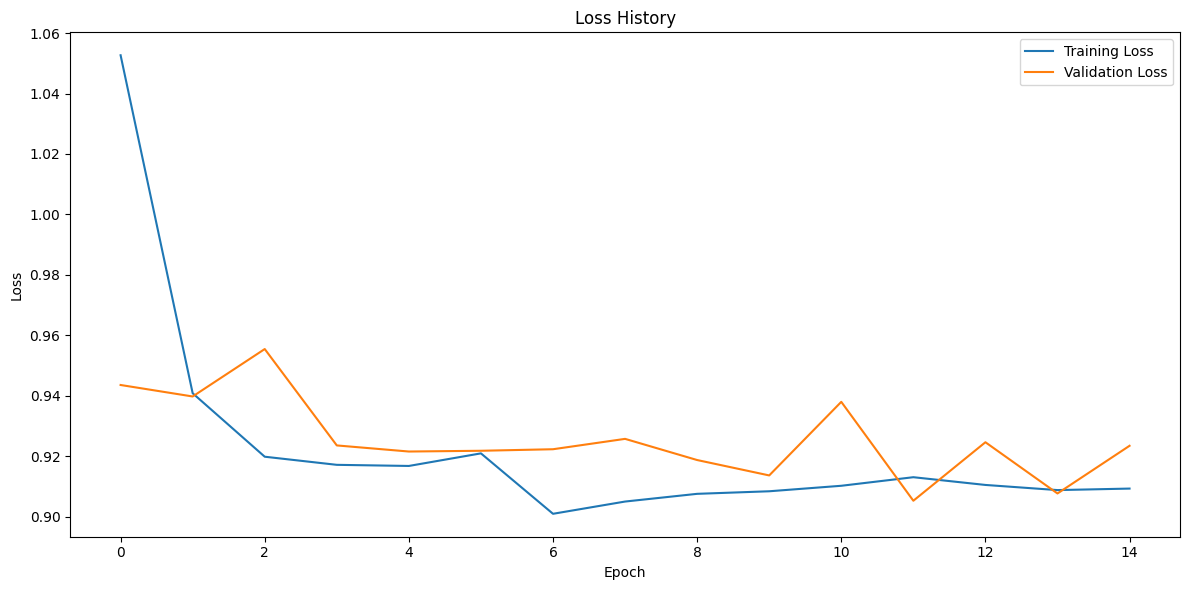

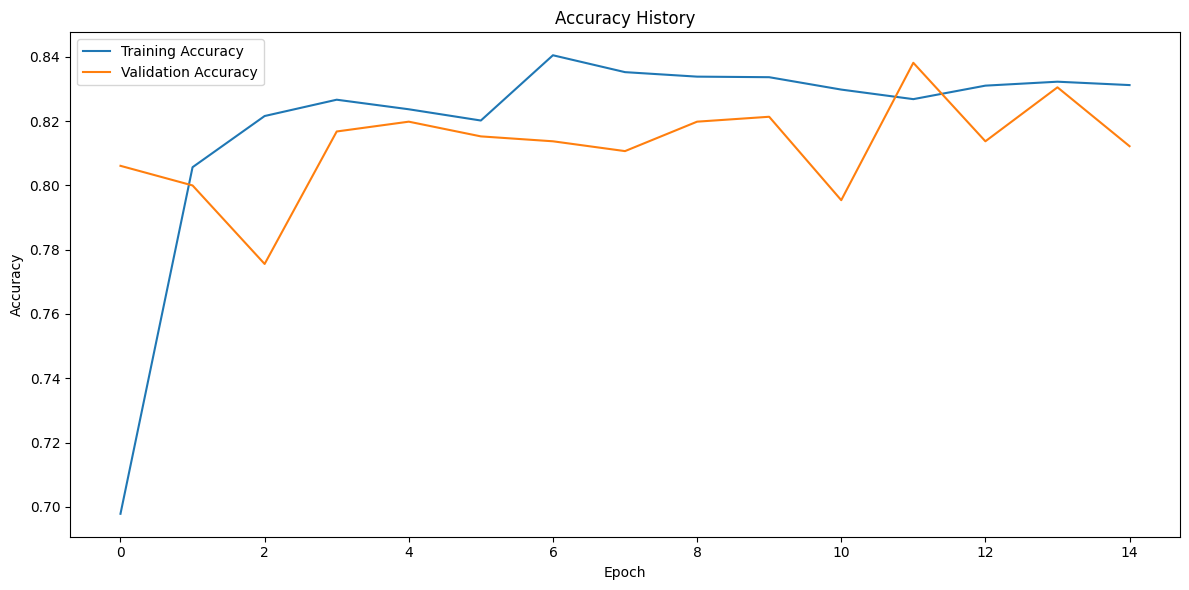

In [ ]:
import matplotlib.pyplot as plt

# Plotting loss history
plt.figure(figsize=(12, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss History')
plt.tight_layout()
plt.show()

# Plotting accuracy history
plt.figure(figsize=(12, 6))
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy History')
plt.tight_layout()
plt.show()


In [ ]:
models = glob("C:/Users/91623/Desktop/Brain_tumor_research/reseach/*")
model_num = [int(i.split("_")[-1]) for i in models if i.split("_")[-1].isdigit()]
best_model_path = "C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_" + str(sorted(model_num)[-1])
best_model_path

'C:/Users/91623/Desktop/Brain_tumor_research/reseach/model_12'

In [ ]:
best_model = CustomInceptionV3(num_classes).to(device)
model_dict = best_model.state_dict()
pretrained_dict = {k: v for k, v in torch.load(best_model_path, map_location=device).items() if k in model_dict}
model_dict.update(pretrained_dict)
best_model.load_state_dict(model_dict)


RuntimeError: Error(s) in loading state_dict for CustomInceptionV3:
	size mismatch for inception.fc.2.weight: copying a param with shape torch.Size([4, 256]) from checkpoint, the shape in current model is torch.Size([5, 256]).
	size mismatch for inception.fc.2.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([5]).